In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Baseline Dataset: Supervised Learning and Random Forests

(a) Briefly describe the differences between a decision tree, bagging and a random forest (for classification). Describe one criterion you can use to measure the quality of a split within a classification tree. Identify two hyperparameters of a single tree within a random forest, and relate one of these to a heuristic involving the number of features.

**Decision Tree**\
A descision tree is a non-parametric supervised learning model that uses the features to make splits to the data to produce regions that are as pure as possible (i.e. all the data points in a region are of the same class).

**Bagging**\
Bagging (bootstrap aggregating) is a general-purpose technique to reduce the variance of a learning method by training multiple models on different subsets of the data, then combining the results.

**Random Forest**\
A random forest is a collection of decision trees, where each tree is trained on a different subset of the data. Furthermore, at each split, only a subset of the features are considered, which introduces variability between the trees in the forest and is the difference between bagging and random forests.

**Criterion**\
One criterion to measure the quality of a split is the Gini impurity, which is defined as:
$$
G(Q_m)=1-\sum_{k=1}^{K}p_{mk}^2
$$
where $K$ is the number of classes, $Q_m$ is the data at node $m$ with $n_m$ samples and $p_{mk}$ is the proportion of training samples in region $m$ that are of class $k$:
$$
p_{mk}=\frac{1}{n_m}\sum_{y_i\in Q_m}I(y_i=k)
$$
where $I$ is the indicator function.\
The Gini impurity is a measure of purity of a node ranging between 0 and 1, where 0 means that all the samples at the node are of the same class and 1 means that the samples are from equally distributed amongst different classes.

**Hyperparameters**\
Two hyperparameters of a single tree within a random forest are the maximum depth of the tree and the maximum number of features to consider when performing a split. A heuristic to determine the value of `max_features` to use for a model is by taking the square root of the total number of features.

(b) Pre-process and filter the data in preparation for the classifier. In your report, explain how you have pre-processed the data and justify any steps you have taken.

In [2]:
df = pd.read_csv('../Data/ADS_baselineDataset.csv', index_col=0)
df.head()

,Fea1,Fea2,Fea3,Fea4,Fea5,Fea6,Fea7,Fea8,Fea9,Fea10,...,Fea992,Fea993,Fea994,Fea995,Fea996,Fea997,Fea998,Fea999,Fea1000,type
Sample1,0.0,1.386294,0.0,0.0,2.639057,0.0,2.944439,0.0,1.098612,0.0,...,2.302585,0.0,1.098612,0.0,0.00000,0.000000,3.496508,0.0,0.000000,2
Sample2,0.0,0.693147,0.0,0.0,1.791759,0.0,2.833213,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.00000,2.484907,3.218876,0.0,0.000000,1
Sample3,0.0,3.891820,0.0,0.0,3.367296,0.0,2.833213,0.0,0.000000,0.0,...,2.302585,0.0,0.000000,0.0,0.00000,3.526361,4.454347,0.0,2.484907,2
Sample4,0.0,3.828641,0.0,0.0,0.000000,0.0,1.945910,0.0,3.401197,0.0,...,0.000000,0.0,2.079442,0.0,1.94591,1.791759,4.406719,0.0,2.772589,3
Sample5,0.0,3.258097,0.0,0.0,1.098612,0.0,2.397895,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.94591,1.098612,2.772589,0.0,1.945910,1


In [3]:
# check for missing values
df.isnull().sum().sum()

0

In [4]:
# check for duplicates
df.duplicated().sum()

0

In [5]:
df.iloc[:, :-1].duplicated().sum()

0

In [6]:
# check for outliers
z_scores = (df - df.mean()) / df.std()
threshold = 3
outliers = z_scores.abs() > threshold

mask = outliers.any(axis=1) > 0
outliers.sum(axis=1)[mask]

Sample1      19
Sample2       9
Sample3       7
Sample4      13
Sample5       7
             ..
Sample496    18
Sample497    16
Sample498    15
Sample499    27
Sample500    10
Length: 500, dtype: int64

In [7]:
mask = outliers.sum(axis=0) > 0
outliers.sum(axis=0)[mask]

Fea1       4
Fea3       6
Fea4       1
Fea6       3
Fea8       7
          ..
Fea992     1
Fea993     7
Fea995     4
Fea998    20
Fea999     2
Length: 728, dtype: int64

In [8]:
print(f'Number of outliers: {outliers.sum().sum()}')
print(f'Proportion of outliers in data: {outliers.sum().sum() / outliers.size:.4%}')

Number of outliers: 6689
Proportion of outliers in data: 1.3365%


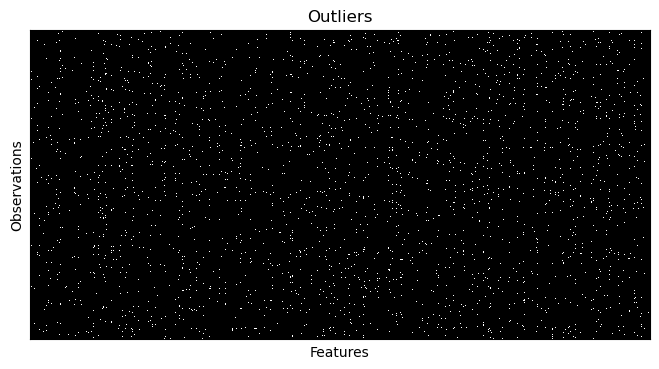

In [9]:
# visualise outliers
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(outliers, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('Outliers')
plt.savefig('../Plots/Q4b_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

Deal with outliers:
1. Split into training and test sets (to avoid data leakage)
2. Identify outliers in each, replace with nan
3. Model-based imputation in train set. Use same model (without retraining) for test set.

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('type', axis=1)
y = df['type']
# stratify to ensure same proportion of classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Identify and remove outliers
def remove_outliers(df, threshold=3):
    z_scores = (df - df.mean()) / df.std()
    outliers = z_scores.abs() > threshold
    print(f'Number of outliers found: {outliers.sum().sum()}')
    print(f'Proportion of outliers in set: {outliers.sum().sum() / outliers.size:.4%}')
    df[outliers] = np.nan

remove_outliers(X_train)
remove_outliers(X_test)

Number of outliers found: 5261
Proportion of outliers in set: 1.3153%
Number of outliers found: 1276
Proportion of outliers in set: 1.2760%


In [12]:
# Model-based imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import time

from sklearn.neighbors import KNeighborsRegressor

# Default Bayesian Ridge Regression
# imputer = IterativeImputer(random_state=42) # too long
imputer = IterativeImputer(random_state=42, estimator=KNeighborsRegressor())

print('Fitting imputer...', end='\r')
start = time.time()
imputer.fit(X_train)
print(f'Imputer fitted in {time.time() - start:.2f} seconds.')

print(f'Transforming training set...', end='\r')
start = time.time()
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
print(f'Training set transformed in {time.time() - start:.2f} seconds.')

print(f'Transforming test set...', end='\r')
start = time.time()
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
print(f'Test set transformed in {time.time() - start:.2f} seconds.')

Imputer fitted in 26.71 seconds.
Training set transformed in 19.53 seconds.
Test set transformed in 3.02 seconds.


In [13]:
# check for missing values
print(f'Number of missing values in training set: {X_train.isnull().sum().sum()}')
print(f'Number of missing values in test set: {X_test.isnull().sum().sum()}')

Number of missing values in training set: 0
Number of missing values in test set: 0


(c) Apply the classifier on training data using the default hyperparameters and summarise the output of the model. Evaluate the test set classification error.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# summarise output of model
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      1.00      0.96        38
           2       1.00      1.00      1.00        36
           3       1.00      0.88      0.94        26

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100



In [15]:
# evaluate test set classification error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(f'Test set accuracy: {accuracy_score(y_test, y_pred):.4f}')

# confusion matrix with labels
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
print(cm)

Test set accuracy: 0.9700
[[38  0  0]
 [ 0 36  0]
 [ 3  0 23]]


(d) Optimise the algorithm with respect to the number of trees in the random forest. You should be able to do this without explicitly performing cross-validation.

NOTE: Not clear what is meant by "without explicitly performing cross-validation".

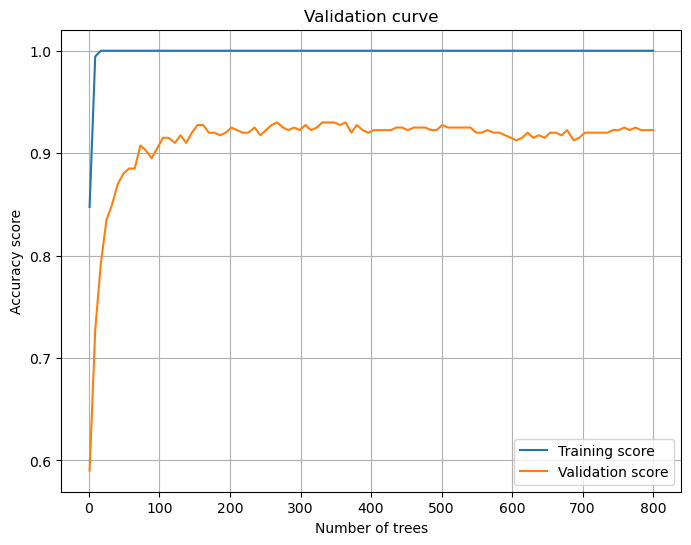

In [16]:
from sklearn.model_selection import validation_curve

# calculate and plot validation curve
param_range = np.linspace(1, 800, 100, dtype=int)
train_scores, test_scores = validation_curve(
    rfc, X_train, y_train, param_name='n_estimators', param_range=param_range, 
    cv=5, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_scores.mean(axis=1), label='Training score')
plt.plot(param_range, test_scores.mean(axis=1), label='Validation score')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('Validation curve')
plt.legend()
plt.grid(True)
plt.savefig('../Plots/Q4d_validation_curve.png', dpi=300, bbox_inches='tight')
plt.show()

Use around 300 trees

(e) Calculate the feature importance. In your report, describe and interpret the feature importance. Retrain the model using a subset of the most important features. In your report, indicate which features you have chosen and compare the retrained classifier with the original classifier.

In [17]:
# Calculate feature importance
rfc_original = RandomForestClassifier(n_estimators=300, random_state=42)
rfc_original.fit(X_train, y_train)

feature_importances = rfc_original.feature_importances_
feature_importances = pd.Series(feature_importances, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)

In [18]:
# What is n so that top n features sum to 0.9?
threshold = 0.9
n = 0
for i in range(len(feature_importances)):
    if feature_importances.iloc[:i].sum() > threshold:
        break
    n += 1
print(f'Top {n} features sum to {feature_importances.iloc[:n].sum():.4f}')

most_important_features = feature_importances.iloc[:n].index
print(most_important_features)

Top 268 features sum to 0.9003
Index(['Fea64', 'Fea70', 'Fea630', 'Fea36', 'Fea354', 'Fea222', 'Fea162',
       'Fea795', 'Fea490', 'Fea673',
       ...
       'Fea221', 'Fea793', 'Fea711', 'Fea362', 'Fea467', 'Fea780', 'Fea90',
       'Fea752', 'Fea670', 'Fea193'],
      dtype='object', length=268)


In [19]:
# Retrain model using subset of most important features
X_train_subset = X_train[most_important_features]

rfc_retrained = RandomForestClassifier(n_estimators=300, random_state=42)
rfc_retrained.fit(X_train_subset, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [20]:
# Compare retrained classifier with original classifier
y_pred_original = rfc_original.predict(X_test)
y_pred_retrained = rfc_retrained.predict(X_test[most_important_features])

# Accuracy
print(f'Original classifier accuracy: {accuracy_score(y_test, y_pred_original):.4f}')
print(f'Retrained classifier accuracy: {accuracy_score(y_test, y_pred_retrained):.4f}')
print()

# Confusion matrix
cm_original = confusion_matrix(y_test, y_pred_original, labels=[1,2,3])
cm_retrained = confusion_matrix(y_test, y_pred_retrained, labels=[1,2,3])
print(f'Confusion matrix from original model:\n{cm_original}')
print(f'Confusion matrix from retrained model:\n{cm_retrained}')

Original classifier accuracy: 0.9400
Retrained classifier accuracy: 0.9400

Confusion matrix from original model:
[[38  0  0]
 [ 0 36  0]
 [ 6  0 20]]
Confusion matrix from retrained model:
[[37  0  1]
 [ 1 35  0]
 [ 4  0 22]]


(f) Repeat steps (b), (c), and (e) for one other supervised learning classifier. Compare and contrast the two classification approaches and your results for each.

In [21]:
# Will use Support Vector Classifier (need to scale data)

# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Train classifier with default params
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train_scaled, y_train)

# Evaluate test set classification error
y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(f'Test set accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(confusion_matrix(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.82      0.97      0.89        38
           2       1.00      0.81      0.89        36
           3       0.88      0.88      0.88        26

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Test set accuracy: 0.8900
[[37  0  1]
 [ 5 29  2]
 [ 3  0 23]]


In [22]:
# Calculate feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(
    svc, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

In [23]:
features = X_test_scaled.columns
feature_importances = pd.Series(result.importances_mean, index=features)
feature_importances.sort_values(ascending=False, inplace=True)

In [24]:
feature_importances

Fea630    0.019
Fea162    0.018
Fea64     0.017
Fea886    0.016
Fea197    0.014
          ...  
Fea781   -0.010
Fea301   -0.010
Fea496   -0.010
Fea219   -0.012
Fea733   -0.020
Length: 1000, dtype: float64

In [25]:
n = 0
for i in range(len(feature_importances)):
    if feature_importances.iloc[i].sum() <= 1e-5:
        break
    n += 1
print(f'Top {n} features are positive.')

most_important_features = feature_importances.iloc[:n].index
print(most_important_features)

Top 208 features are positive.
Index(['Fea630', 'Fea162', 'Fea64', 'Fea886', 'Fea197', 'Fea144', 'Fea633',
       'Fea314', 'Fea591', 'Fea795',
       ...
       'Fea74', 'Fea887', 'Fea917', 'Fea171', 'Fea159', 'Fea111', 'Fea101',
       'Fea926', 'Fea851', 'Fea138'],
      dtype='object', length=208)


In [26]:
# Retrain model using most important features
X_train_subset = X_train_scaled[most_important_features]

svc_retrained = SVC(random_state=42)
svc_retrained.fit(X_train_subset, y_train)

SVC(random_state=42)

In [27]:
# Compare retrained classifier with original classifier
y_pred_original = svc.predict(X_test_scaled)
y_pred_retrained = svc_retrained.predict(X_test_scaled[most_important_features])

# Accuracy
print(f'Original classifier accuracy: {accuracy_score(y_test, y_pred_original):.4f}')
print(f'Retrained classifier accuracy: {accuracy_score(y_test, y_pred_retrained):.4f}')
print()

# Confusion matrix
cm_original = confusion_matrix(y_test, y_pred_original, labels=[1,2,3])
cm_retrained = confusion_matrix(y_test, y_pred_retrained, labels=[1,2,3])
print(f'Confusion matrix from original model:\n{cm_original}')
print(f'Confusion matrix from retrained model:\n{cm_retrained}')

Original classifier accuracy: 0.8900
Retrained classifier accuracy: 0.8800

Confusion matrix from original model:
[[37  0  1]
 [ 5 29  2]
 [ 3  0 23]]
Confusion matrix from retrained model:
[[37  1  0]
 [ 3 33  0]
 [ 7  1 18]]
